# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [8]:
from sklearn.datasets import make_moons, make_circles, make_classification
dataset1 = make_circles(noise=0.2, factor=0.5, random_state=42)
dataset2 = make_moons(noise=0.2, random_state=42)
dataset3 = make_classification(
    n_classes=3, 
    n_clusters_per_class=1, 
    n_features=2, 
    class_sep=0.8, 
    random_state=3,
    n_redundant=0,
    n_informative=2
)

datasets = [dataset1, dataset2, dataset3]

In [9]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

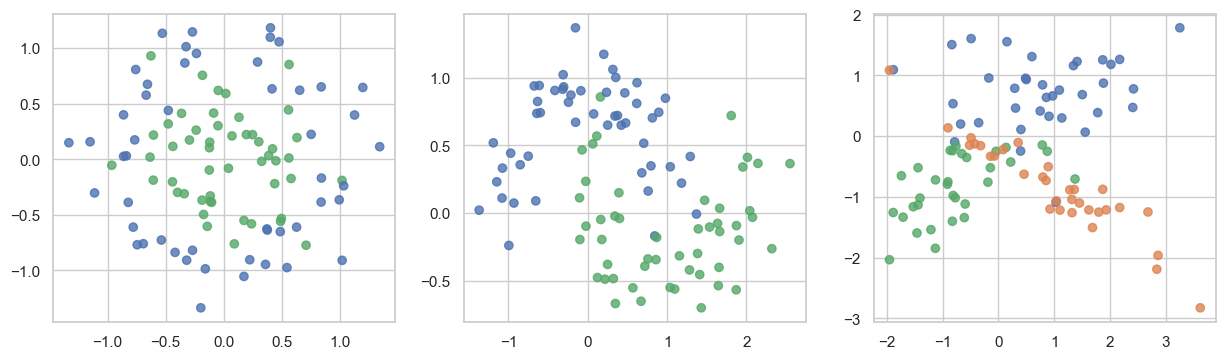

In [10]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [11]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

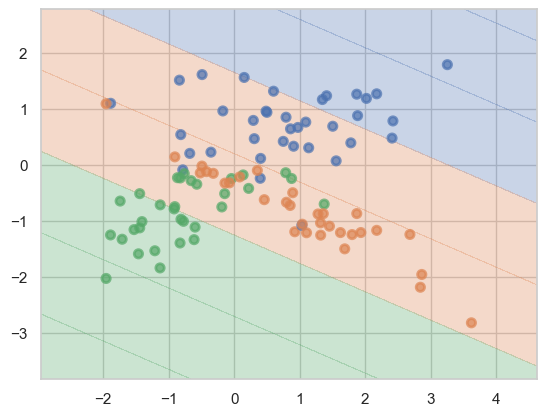

In [13]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

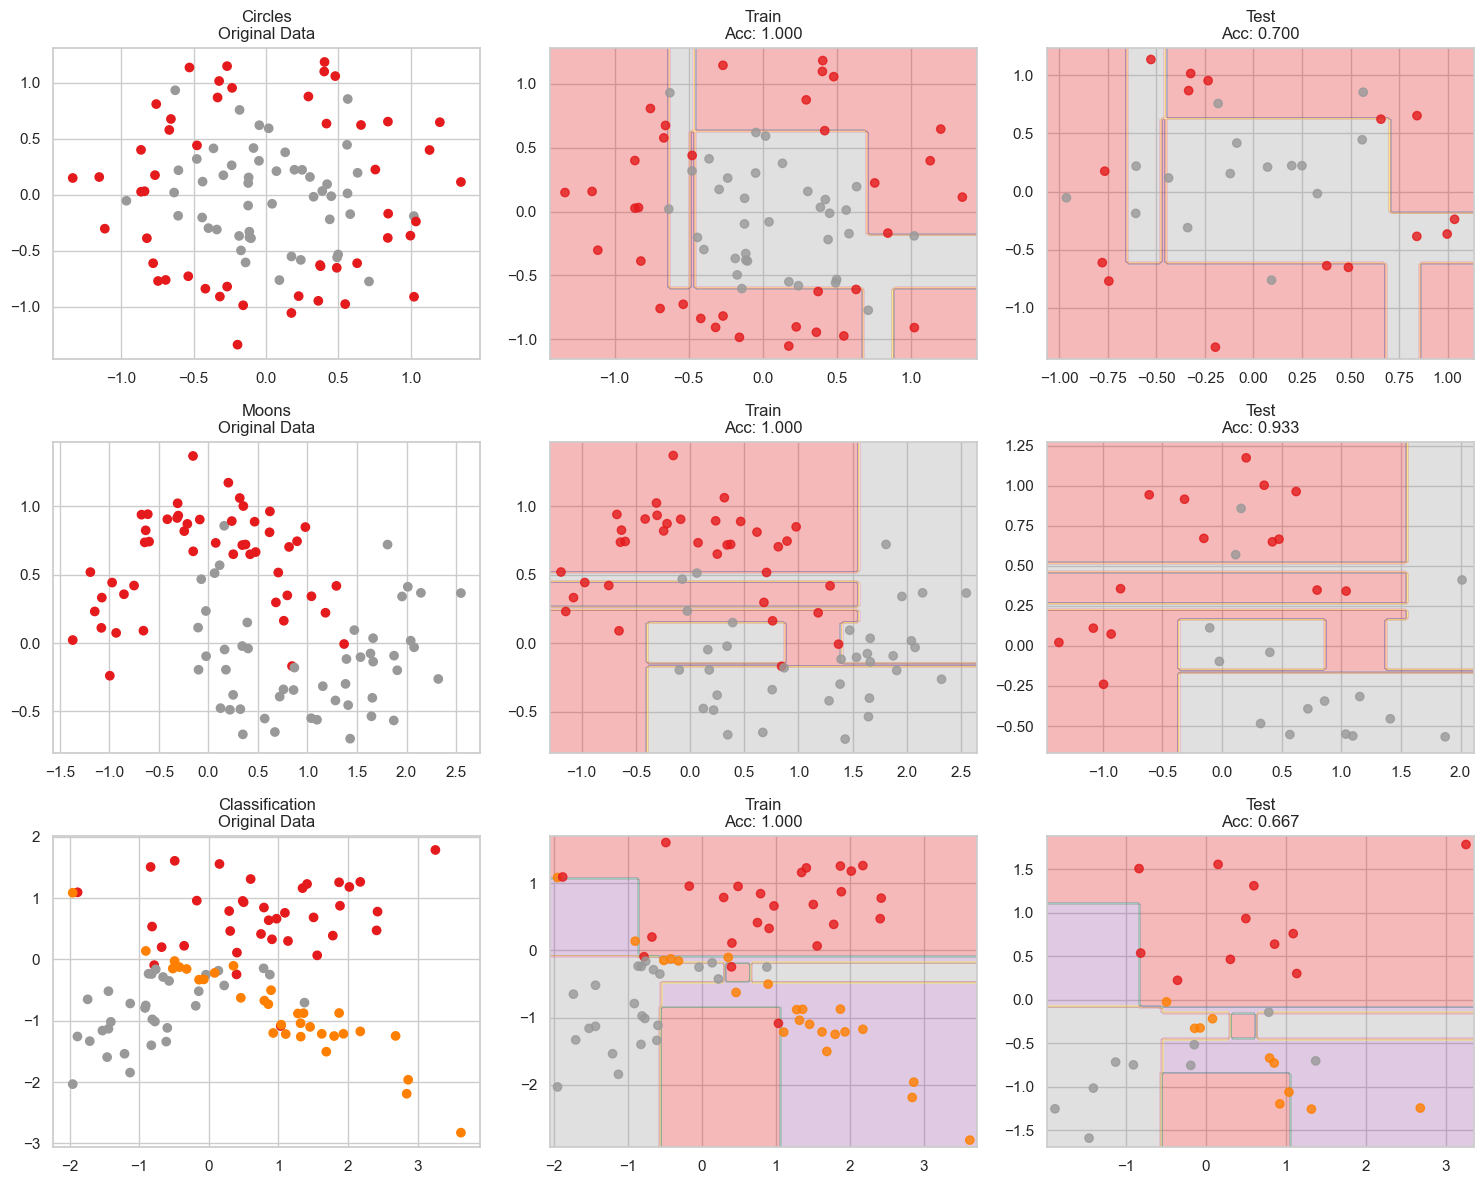

Результаты анализа переобучения:
Circles         | Train: 1.000 | Test: 0.700 | Overfit: 0.300 | Сильное переобучение
Moons           | Train: 1.000 | Test: 0.933 | Overfit: 0.067 | Стабильно
Classification  | Train: 1.000 | Test: 0.667 | Overfit: 0.333 | Сильное переобучение

Время выполнения: 3.06 сек


In [33]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.metrics import accuracy_score
import time

def plot_decision_surface(clf, X, y, ax):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, alpha=0.8)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

start_time = time.time()

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
dataset_names = ['Circles', 'Moons', 'Classification']
results_data = []

for idx, (X_data, y_data) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.3, random_state=42, stratify=y_data
    )
    
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    
    train_accuracy = classifier.score(X_train, y_train)
    test_accuracy = classifier.score(X_test, y_test)
    
    results_data.append({
        'dataset': dataset_names[idx],
        'train_acc': train_accuracy,
        'test_acc': test_accuracy,
        'overfitting': train_accuracy - test_accuracy
    })
    
    axes[idx, 0].scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=plt.cm.Set1)
    axes[idx, 0].set_title(f'{dataset_names[idx]}\nOriginal Data')
    
    plot_decision_surface(classifier, X_train, y_train, axes[idx, 1])
    axes[idx, 1].set_title(f'Train\nAcc: {train_accuracy:.3f}')
    
    plot_decision_surface(classifier, X_test, y_test, axes[idx, 2])
    axes[idx, 2].set_title(f'Test\nAcc: {test_accuracy:.3f}')

plt.tight_layout()
plt.show()

execution_time = time.time() - start_time

print("Результаты анализа переобучения:")
print("=" * 50)
for result in results_data:
    status = "Сильное переобучение" if result['overfitting'] > 0.1 else "Стабильно"
    print(f"{result['dataset']:15} | Train: {result['train_acc']:.3f} | Test: {result['test_acc']:.3f} | Overfit: {result['overfitting']:.3f} | {status}")

print(f"\nВремя выполнения: {execution_time:.2f} сек")

__Ответ:__Деревья с параметрами по умолчанию демонстрируют сильное переобучение на двух из трех датасетов.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

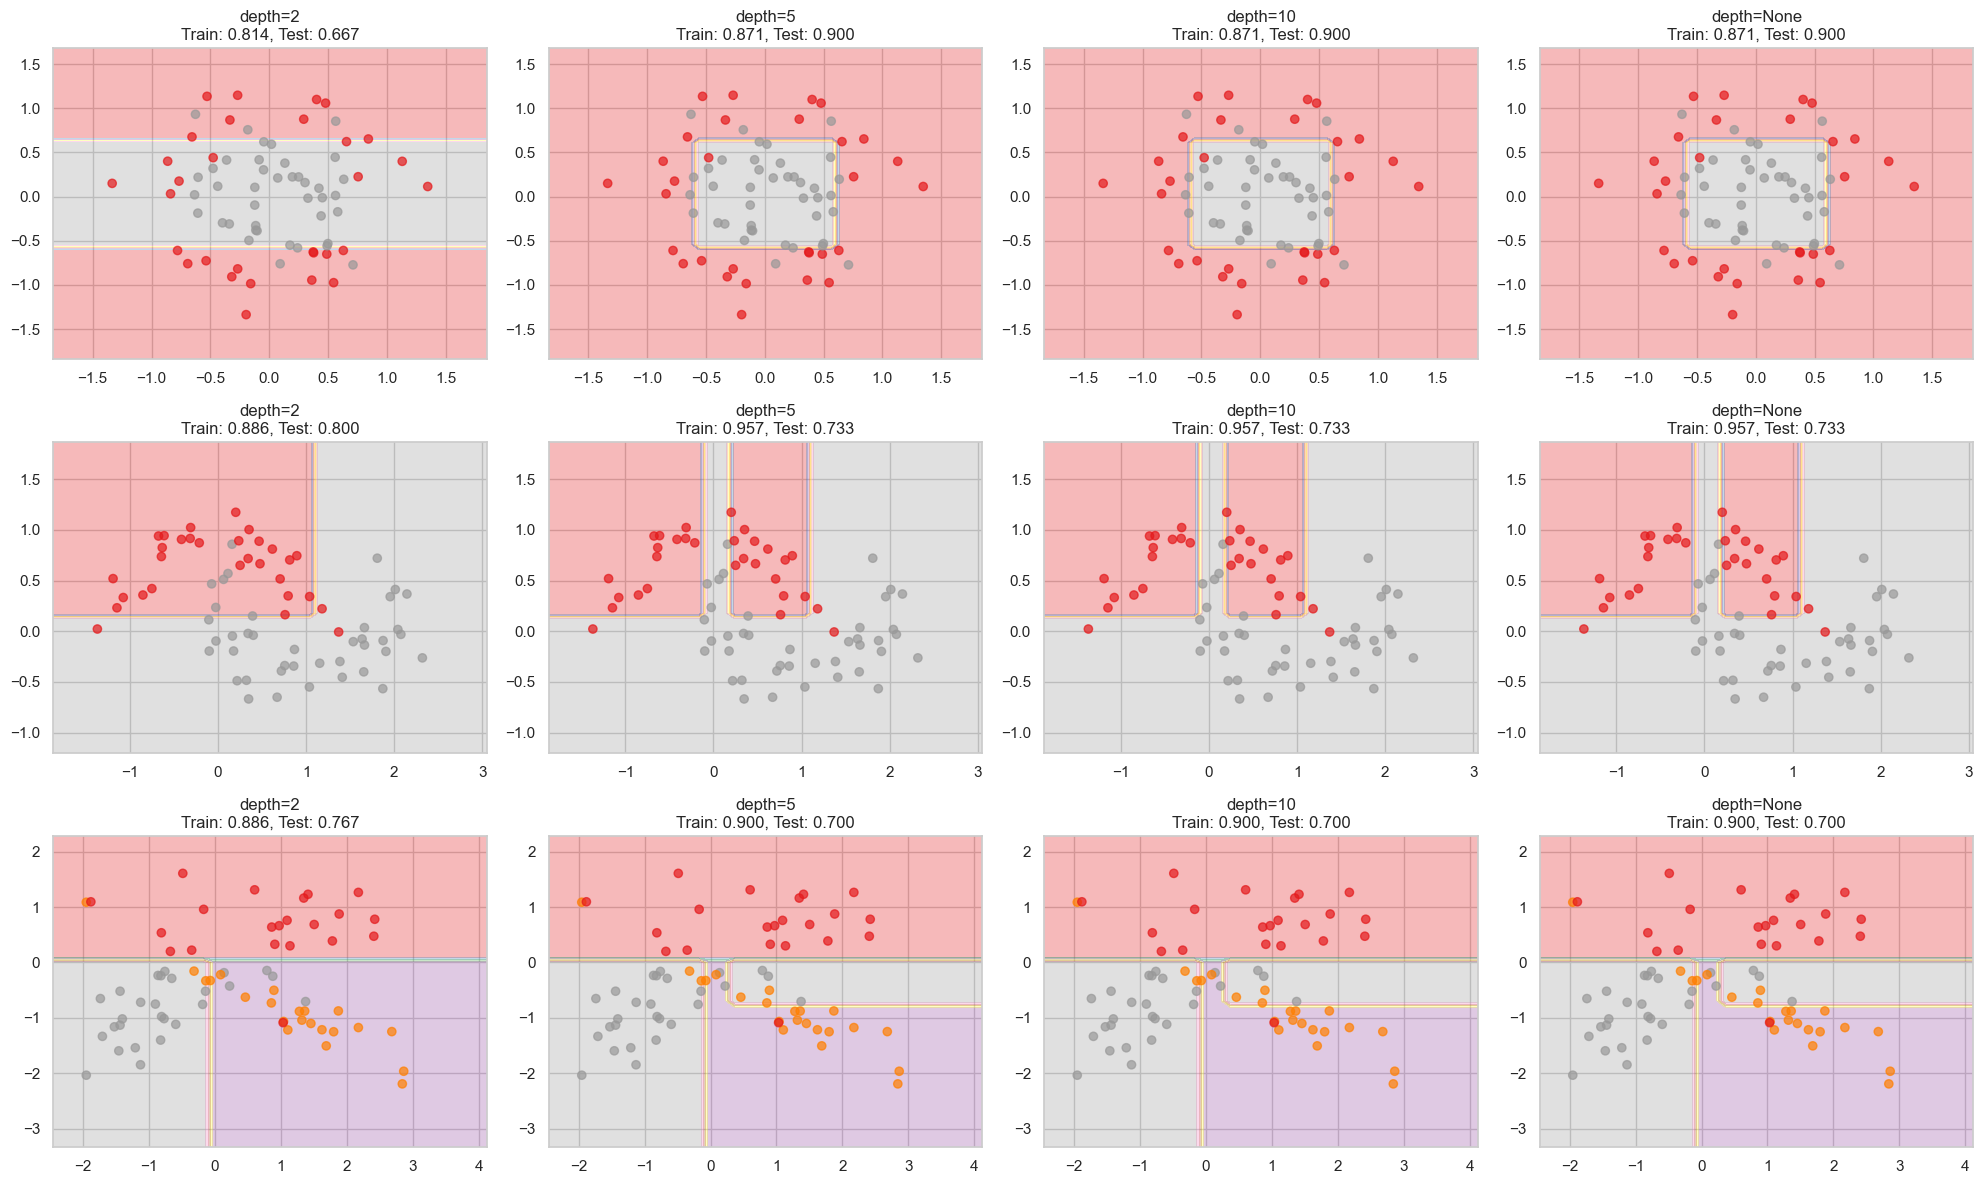

In [34]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
max_depth_values = [2, 5, 10, None]
min_samples_leaf_values = [1, 5, 10]

fig, axes = plt.subplots(len(datasets), len(max_depth_values), figsize=(20, 12))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for j, max_depth in enumerate(max_depth_values):
        dt = DecisionTreeClassifier(
            max_depth=max_depth, 
            min_samples_leaf=5,
            random_state=42
        )
        dt.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, dt.predict(X_train))
        test_acc = accuracy_score(y_test, dt.predict(X_test))
        
        x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                            np.linspace(y_min, y_max, 50))
        
        Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axes[i, j].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
        axes[i, j].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Set1, alpha=0.7)
        
        depth_str = "None" if max_depth is None else str(max_depth)
        axes[i, j].set_title(f'depth={depth_str}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}')

plt.tight_layout()
plt.show()

__Ответ:__

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Вставьте что угодно, описывающее ваши впечатления от этого задания: